In [97]:
import os
import pandas as pd
import re
from collections import defaultdict
from datasets import Dataset



from parser import clean, get_resume_sections

df = pd.read_csv("UpdatedResumeDataSet.csv", encoding="utf-8")
df.drop_duplicates(subset=["Resume"], keep="first", inplace=True)
df.reset_index(inplace=True, drop=True)
df["Clean"] = df["Resume"].apply(clean)

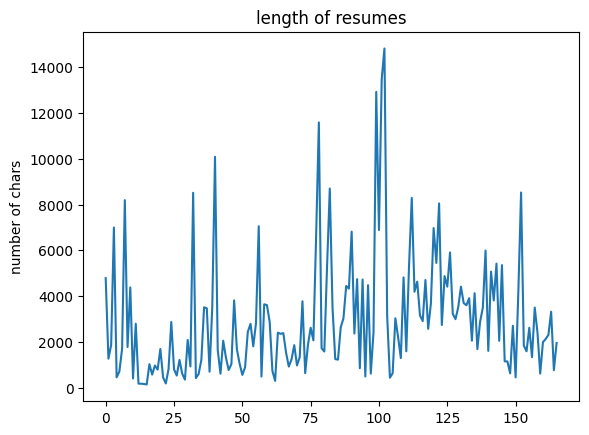

In [98]:
import matplotlib.pyplot as plt

lengths = []
for row in df["Clean"]:
    lengths.append(len(row))

plt.plot(lengths)
plt.title("length of resumes")
plt.ylabel("number of chars")
plt.show()



In [99]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import numpy as np

model_name = "thenlper/gte-base"
embedding_model = HuggingFaceEmbeddings(model_name=model_name)
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len
)

To test this, reduce chunk_size and chunk_overlap from earlier

In [100]:
text = "hello there my guy you are such a guy dude guy yaya yaya"

def chunk_data(text):
    docs = splitter.create_documents(texts=[text])
    return [doc.page_content for doc in docs]

def embed_chunks(chunks):
    return embedding_model.embed_documents(chunks)

chunks = chunk_data(text)
print(chunks)
embedded = embed_chunks(chunks)
print(embedded)
    

['hello there my guy you are such a guy dude guy yaya yaya']
[[-0.0012242910452187061, -0.012970250099897385, 0.009754830971360207, 0.019019102677702904, 0.026360496878623962, 0.010024252347648144, 0.05536678060889244, 0.06483981758356094, -0.0386713482439518, -0.0584564134478569, -0.014085439965128899, 0.011918534524738789, -0.04137302190065384, 0.004030672367662191, -0.015703285112977028, 0.07356765866279602, 0.07172895222902298, 0.0019875038415193558, 0.02538573183119297, 0.005252043250948191, -0.004389501642435789, 0.0007695987587794662, 0.02632075361907482, 0.0071949721314013, 0.014643811620771885, -0.013764429837465286, -0.033641934394836426, 0.04402585327625275, -0.07076282799243927, -0.022726763039827347, 0.03516467288136482, 0.0017697378061711788, 0.012717221863567829, -0.039876971393823624, -0.04122529551386833, -0.020886102691292763, -0.010542168281972408, 0.006501937285065651, 0.005712850950658321, -0.01801019161939621, -0.022091932594776154, -0.013020866550505161, -0.02783

In [101]:
df = df[:5]
df["Chunks"] = df["Clean"].apply(chunk_data)
df["Embeddings"] = df["Chunks"].apply(embed_chunks)
df

,Category,Resume,Clean,Chunks,Embeddings
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills * Programming Languages: Python (pandas...,[Skills * Programming Languages: Python (panda...,"[[0.01287016086280346, -0.01536303386092186, 0..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details \r\nMay 2013 to May 2017 B.E...,[Education Details \r\nMay 2013 to May 2017 B....,"[[0.02041388303041458, -0.019160525873303413, ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","Areas of Interest Deep Learning, Control Syste...","[Areas of Interest Deep Learning, Control Syst...","[[0.02442571334540844, 0.01927502639591694, -0..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Table...,[Skills R Python SAP HANA Tabl...,"[[0.007373979315161705, 0.012433757074177265, ..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","Education Details \r\n MCA YMCAUST, Faridab...","[Education Details \r\n MCA YMCAUST, Farida...","[[0.02551179751753807, -0.03329223394393921, 0..."


Embedding lengths are determined by model, so all will be the same

In [102]:
example = df["Embeddings"][0]
lengths = set([len(x) for x in example])
print(lengths)
EMBEDDING_LENGTH = list(lengths)[0]

{768}


Download postgres and run service


#### Statements to understand
```sql
CREATE TABLE name(
    val1 type1,
    val2 type2,
    val3 type3
)   
```
Create a table called name where each row (or record) keeps information on keys val1... with type type1...
```sql
INSERT INTO name (val1, val2, val3) VALUES (input1, input2, input3)
```
Insert the new record where val1 = input1, etc
```sql
SELECT * FROM name
```
Get every column of data for every row of name

In [103]:
from random import randint
import psycopg
from pgvector.psycopg import register_vector


TABLE_NAME = "resume_docs"

def load_db(df):
    with psycopg.connect("user=postgres") as conn:
        conn.execute('CREATE EXTENSION IF NOT EXISTS vector')
        register_vector(conn)
        with conn.cursor() as cur:
            cur.execute(f"DROP TABLE IF EXISTS {TABLE_NAME}")
            cur.execute(
                f"""
                CREATE TABLE {TABLE_NAME}(
                    id serial PRIMARY KEY,
                    source_id integer,
                    chunk text,
                    embedding vector({EMBEDDING_LENGTH})
                )   
                """
            )

            for i, row in df.iterrows():
                embeds = row["Embeddings"]
                chunks = row["Chunks"]
                for i in range(len(embeds)):
                    cur.execute(
                        f"INSERT INTO {TABLE_NAME} (source_id, chunk, embedding) VALUES (%s, %s, %s)", 
                        (i, chunks[i], embeds[i])
                    )

            for x in cur.execute(f"SELECT * FROM {TABLE_NAME}"):
                print(x)

load_db(df)

(1, 0, 'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, Na  ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language', array([ 1.28701609e-02, -1.53630339e-02,  2.88521741e-02,  3.53265814e-02,
        7.26518333e-02,  4.75492515e-02,  3.74837108e-02,  1.76886544e-02,
       -2.34543942e-02, -4.52238470e-02, -2.32083239e-02,  4.03015688e-02,
       -5.44928759e-02,  1.13327289e-03,  1.62371993e-02,  4.31826748e-02,
        4.98374254e-02,  8.24182108e-03,  2.62066163e-02, -4.01218422e-03,
       -2.50265524e-02, -2.25974116e-02,  5.30881714e-03,  2.20796634e-02,
        9.45714954e-03, -1.42748253e-02,  1.82391144e-03,  1.12004299e-02,
       -8.52903798e-02,  1.02386689e-02,  5.59041165e-02,  1.93874165e-02,
       -1.16336159e-02, -1.23493504e-02, -9.37064365e-03,  3.17157549e-03,
        1.3248946

#### Selecting top K for SQL

General form:
```sql
SELECT * FROM table_name ORDER BY expression LIMIT k
```
Sort table_name by some some expression eg. (arg1, |arg1 - input|). Take just the top K


For our use case, it will look like this:

```sql
SELECT * FROM resume_docs ORDER BY embedding <-> query::vector LIMIT k
```
Where we order by embedding <-> query::vector where <-> gets cosine similarity from each rows embedding to our query embedding, which we explicitly cast to vector with ::vector. Then we take k closest

This is how we get embed our query

In [ ]:
query = "give me someone with software engineering experience"
query = embedding_model.embed_query(query)
print(query)
print(len(query))

[0.022511716932058334, 0.034850720316171646, -0.03828651085495949, 0.028686335310339928, 0.0669453889131546, 0.0016157837817445397, 0.04721405357122421, 0.021688176319003105, 0.0028032411355525255, -0.053106244653463364, -0.012069936841726303, 0.02490764856338501, -0.06599428504705429, 0.01332907471805811, -0.018487323075532913, 0.05695062130689621, 0.04884261637926102, 0.0019117322517558932, 0.028288085013628006, -0.004699026234447956, -0.010423772037029266, 0.025054506957530975, -0.007783595472574234, -0.001280068070627749, -0.0076367734000086784, -0.02998163551092148, 0.00016355358820874244, -0.006825693883001804, -0.056745629757642746, -0.002807231619954109, 0.028862647712230682, -0.021203989163041115, -0.025889737531542778, -0.050031911581754684, -0.06968700140714645, 0.017646677792072296, 0.015790777280926704, -0.0005512829520739615, -0.0073262471705675125, -0.022412706166505814, -0.028180953115224838, -0.013895634561777115, -0.011107447557151318, -0.0037797573022544384, -0.05250

In [125]:
def get_top_k(query, k):
    query = embedding_model.embed_query(query)
    with psycopg.connect("user=postgres") as conn:
        with conn.cursor() as cur:
            res = cur.execute(f"SELECT * FROM {TABLE_NAME} ORDER BY embedding <-> %s::vector LIMIT %s", (query, k)).fetchall()
            return res

query = "experience with machine learning and data analytics"
k = 10
res = get_top_k(query, 10)
res

[(1,
  0,
  'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, Na  ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language',
  '[0.012870161,-0.015363034,0.028852174,0.03532658,0.07265183,0.04754925,0.03748371,0.017688654,-0.023454394,-0.045223847,-0.023208324,0.04030157,-0.054492876,0.0011332729,0.0162372,0.043182675,0.049837425,0.008241821,0.026206616,-0.004012184,-0.025026552,-0.022597412,0.005308817,0.022079663,0.00945715,-0.014274825,0.0018239114,0.01120043,-0.08529038,0.010238669,0.055904116,0.019387417,-0.011633616,-0.01234935,-0.009370644,0.0031715755,0.0132489465,0.04293166,0.001094776,0.005202205,-0.03491688,-0.008748669,-0.0240114,0.048927464,-0.050928716,0.0040722615,-0.05669541,0.023788704,0.006078845,-0.013429698,-0.051151376,0.065864325,0.026526386,-0.02213246,-0.029151693,0.06469623,0.

In [ ]:
# def retrieve_k_closest(query, k):
#     with open()